In [1]:
import numpy as np
from pydrake.all import (StartMeshcat, MeshcatVisualizer, DiagramBuilder, 
                         GenerateHtml, AddMultibodyPlantSceneGraph, Parser,
                         FindResourceOrThrow, Simulator, InverseDynamicsController)

# For diagram viz
from IPython.display import SVG
import pydot

In [2]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7002


In [3]:
# "Diagram" is the whole drake block diagram dictating how subsystems interact
# First it's in the form of a "builder", we add subsystems, then we finalize it into a full "diagram"
builder = DiagramBuilder()

# Adds both MultibodyPlant and the SceneGraph, and wires them together.
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)

# Add a kuka iiwa into the plant and scene graph
# Not sure what Parser does, something to do with adding models
iiwa_model = Parser(plant, scene_graph).AddModelFromFile(
        FindResourceOrThrow("drake/manipulation/models/iiwa_description/sdf/iiwa14_no_collision.sdf"))

# Make kuka sit in the center of the world
plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0"))

# Build connections between multibody plant and scene graph
plant.Finalize()


# Adds the MeshcatVisualizer and wires it to the SceneGraph.
visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)


## NOTE: In a simulation with no controller, the robot would experience zero torques and just fall.
## IRL there is a low level controller to keep the iiwa just existing and standing up, so this is simulating
## that low level passive controller

## Question
# The inverse dynamics controller doesn't do much in terms of imposing force, velocity limitations.
# What about joint limits? How can we ensure the robot doesn't violate these constraints? Is that
# something we only impose when sending a desired configuration?

# # Sends '0' commands to joint actuators --> robot falls
# plant.get_actuation_input_port().FixValue(plant_context, np.zeros(7))

# Create a PID controller
Kp = np.full(7, 100)
Ki = np.full(7, 1)
Kd = 2 * np.sqrt(Kp)

## Question
# Why is this controller called 'Inverse Dynamics'? I thought inverse dynamics was mapping from end effector space
# to joint space. This controller seems like it maps the inverse of the function qdotdot = f(q, qdot, u) to solve
# for actuation term u given torque = I*qdotdot.
## NOTE: One is "inverse dynamics", one is "inverse kinematics"
iiwa_controller = builder.AddSystem(InverseDynamicsController(plant, Kp, Ki, Kd, False))
iiwa_controller.set_name("iiwa_controller");

# Connect the multibody truth state to iiwa controller input estimation (no estimation error)
builder.Connect(plant.get_state_output_port(iiwa_model),
                iiwa_controller.get_input_port_estimated_state())

## Question
# Connect the control output to the multibody actuation input port
# (I would expect this to go to the iiwa plant input port, not the multibody input port. 
# Perhaps it passes from multibody --> iiwa on its own?)
builder.Connect(iiwa_controller.get_output_port_control(),
                plant.get_actuation_input_port())


# Finalize diagram
diagram = builder.Build()
diagram.set_name("diagram")

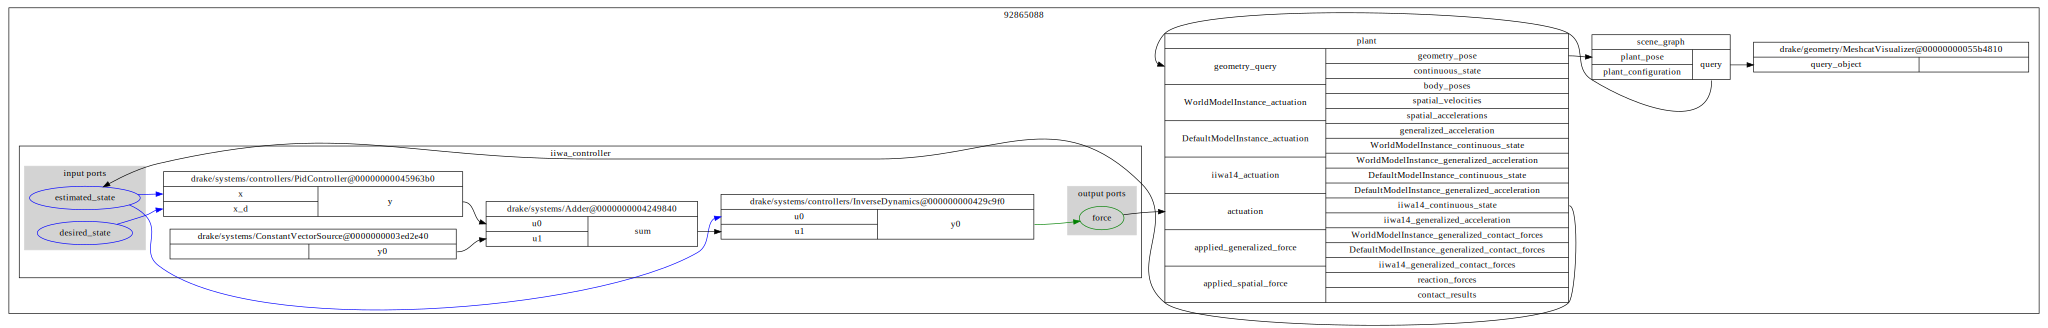

In [55]:
# Visualize a diagram
SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg())

## Question
# I would expect the iiwa to be a subsystem of the MultiBodyPlant, but it looks like they are pretty intertwined?
# How does the delineation work? If we have a multibody system with like 8 kukas, how can we just send joint
# commands through the multibody plants input port "actuation"? Don't we need more specificity?

In [4]:
# Initialize robot state and get subsystem contexts
context = diagram.CreateDefaultContext()
diagram.Publish(context)
plant_context = plant.GetMyMutableContextFromRoot(context)
iiwa_controller_context = iiwa_controller.GetMyMutableContextFromRoot(context)

# Set desired joint locations - x0 is pos (q0) & vel (zeros)
q0 = np.array([-1.57, 0.1, 0, -1.2, 0, 1.6, 0])
x0 = np.hstack((q0, 0*q0))
plant.SetPositions(plant_context, q0)
iiwa_controller.GetInputPort('desired_state').FixValue(
    iiwa_controller_context, x0)
# To see controller actuating to a different location:
# x = 1.2*x0
# iiwa_controller.GetInputPort('desired_state').FixValue(
#     iiwa_controller_context, x)

# Run simulation for 5 seconds
simulator = Simulator(diagram, context)
simulator.set_target_realtime_rate(1.0)
visualizer.StartRecording()
simulator.AdvanceTo(5.0)
visualizer.PublishRecording()

## Question
# When adding a PID to compensate for gravity, I would expect it would still bobble around quite a bit at first.
# As in, initial commanded torque @ joints is 0 because everything is lined up and no integration terms have accrued.
# Then gravity would start pulling the robot down and it has to keep itself up. 
# In this simulation, it's just perfectly still. How is that possible?